Synthesizing [adversarial examples](https://arxiv.org/abs/1312.6199) for neural networks is surprisingly easy: small, carefully-crafted perturbations to inputs can cause neural networks to misclassify inputs in arbitrarily chosen ways. Given that adversarial examples [transfer to the physical world](https://arxiv.org/abs/1607.02533) and [can be made extremely robust](https://blog.openai.com/robust-adversarial-inputs/), this is a real security concern.

In this post, we give a brief introduction to algorithms for synthesizing adversarial examples, and we walk through the process of implementing attacks in [TensorFlow](https://www.tensorflow.org/), building up to synthesizing a robust adversarial example following [this technique](https://arxiv.org/abs/1707.07397).

**This post is an executable [Jupyter notebook](http://jupyter.org/): you're encouraged to [download it](/media/2017/07/25/adversarial.ipynb) and experiment with the examples yourself!**

# Setup

We choose to attack an [Inception v3](https://arxiv.org/abs/1512.00567) network trained on [ImageNet](http://www.image-net.org/). In this section, we load a pre-trained network from the [TF-slim image classification library](https://github.com/tensorflow/models/tree/master/slim). This part isn't particularly interesting, so **feel free to [skip this section](#adversarial-examples)**.

In [108]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets
# from nets import inception_resesnet_v2
#from inception_resnet_v2 import *
#import inception_preprocessing
import tempfile
from urllib.request import urlretrieve
import tarfile
import os
import json
import matplotlib.pyplot as plt
import PIL
import numpy as np

In [109]:
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

D:\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


First, we set up the input image. We use a `tf.Variable` instead of a `tf.placeholder` because we will need it to be trainable. We can still feed it when we want to.

In [110]:
image = tf.Variable(tf.zeros((299, 299, 3)))
data_dir = tempfile.mkdtemp()

Next, we load the Inception v3 model.

In [111]:
def inception_v3(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
#         print(probs)
#加载参数
    inception_tarball='D:\\jupyter\\adversanial\\inception_v3_2016_08_28.tar.gz'
    tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)
    restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
    ]
#     saver = tf.train.Saver(restore_vars)
#     saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))
    return logits,probs

def resnet(image):
    tf.reset_default_graph()
#     processed_image = inception_preprocessing.preprocess_image(image,299,299,is_training=False,)
#     processed_images  = tf.expand_dims(processed_image, 0)
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.resnet_v2.arg_scope(weight_decay=0.0)
    
    with slim.arg_scope(arg_scope):
        logits, end_points = nets.resnet_v2(
            preprocessed, 1001, is_training=False) 
        logits = logits[:,1:]
        probabilities = tf.nn.softmax(logits)
    print(probs)
    return logits, probs


#     with tf.Session() as sess:
#         saver.restore(sess, checkpoint_file)

#         #predict_values, logit_values = sess.run([end_points['Predictions'], logits])
#         image2, network_inputs, probabilities2 = sess.run([image,
#                                                            processed_images,
#                                                            probabilities])

#         print(network_inputs.shape)
#         print(probabilities2.shape)
#         probabilities2 = probabilities2[0,:]
#         sorted_inds = [i[0] for i in sorted(enumerate(-probabilities2),
#                                             key=lambda x:x[1])]    


# logits, probs = resnet(image)
# print(logits)

TypeError: arg_scope() missing 1 required positional argument: 'list_ops_or_scope'

Next, we load pre-trained weights. This Inception v3 has a top-5 accuracy of 93.9%.

Next, we write some code to show an image, classify it, and show the classification result.

In [85]:

def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    ax1.tick_params(axis='x',colors ='white')
    ax1.tick_params(axis='y',colors ='white')
    fig.sca(ax1)
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
#     topprobs[0]=0.75
#     topprobs[1]=0.15
#     topprobs[2]=0.08
#     topprobs[3]=0.02
    print(topprobs)
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    ax2.tick_params(axis='y',colors ='white')
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical',color='white')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

## Example image

We load our example image and make sure it's classified correctly.

In [86]:

img_path, _ = urlretrieve('https://timgsa.baidu.com/timg?image&quality=80&size=b9999_10000&sec=1572254695068&di=0de174eab6020439abc940ae575819ff&imgtype=0&src=http%3A%2F%2Fdpic.tiankong.com%2F00%2Fzu%2FQJ6543291920.jpg%3Fx-oss-process%3Dstyle%2Fshows')
img_class = 151
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)

[0.63760394 0.06553011 0.03097374 0.01606182 0.01126853 0.00682838
 0.00637947 0.00284663 0.00237937 0.0022341 ]


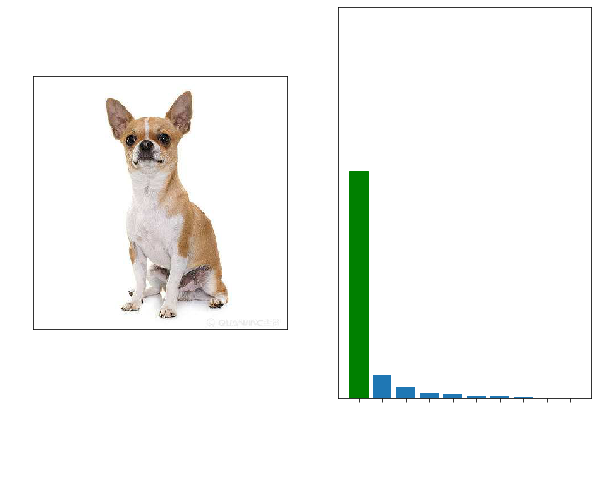

In [87]:
classify(img, correct_class=img_class)

# Adversarial examples

Given an image $\mathbf{x}$, our neural network outputs a probability distribution over labels, $P(y \mid \mathbf{x})$. When we craft an adversarial input, we want to find an $\hat{\mathbf{x}}$ where $\log P(\hat{y} \mid \hat{\mathbf{x}})$ is maximized for a target label $\hat{y}$: that way, our input will be misclassified as the target class. We can ensure that $\hat{\mathbf{x}}$ doesn't look too different from the original $\mathbf{x}$ by constraining ourselves to some $\ell_\infty$ box with radius $\epsilon$, requiring that $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$.

In this framework, an adversarial example is the solution to a constrained optimization problem that we can solve using [backpropagation](http://colah.github.io/posts/2015-08-Backprop/) and projected gradient descent, basically the same techniques that are used to train networks themselves. The algorithm is simple:

We begin by initializing our adversarial example as $\hat{\mathbf{x}} \leftarrow \mathbf{x}$. Then, we repeat the following until convergence:

1. $\hat{\mathbf{x}} \leftarrow \hat{\mathbf{x}} + \alpha \cdot \nabla \log P(\hat{y} \mid \hat{\mathbf{x}})$
2. $\hat{\mathbf{x}} \leftarrow \mathrm{clip}(\hat{\mathbf{x}}, \mathbf{x} - \epsilon, \mathbf{x} + \epsilon)$

## Initialization

We start with the easiest part: writing a TensorFlow op for initialization.

In [ ]:
x = tf.placeholder(tf.float32, (299, 299, 3))
x_hat = image # our trainable adversarial input
assign_op = tf.assign(x_hat, x)

## Gradient descent step

Next, we write the gradient descent step to maximize the log probability of the target class (or equivalently, minimize the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy)).

In [ ]:
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 1000)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(-loss, var_list=[x_hat])


## Projection step

Finally, we write the projection step to keep our adversarial example visually close to the original image. Additionally, we clip to $[0, 1]$ to keep it a valid image.

In [34]:

epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

NameError: name 'x' is not defined

## Execution

Finally, we're ready to synthesize an adversarial example. We arbitrarily choose "guacamole" (imagenet class 924) as our target class.

In [35]:
demo_epsilon = 8.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
demo_target = img_class # dog

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # retrieve the adversarial example

NameError: name 'img_class' is not defined

This adversarial image is visually indistinguishable from the original, with no visual artifacts. However, it's classified as "guacamole" with high probability!

In [36]:
classify(adv, correct_class=img_class, target_class=demo_target)

NameError: name 'classify' is not defined

## v1

## v2 


diff=adv-img
# enhance=diff-np.min(diff)
# enhance=np.int0(np.exp(80*(diff-np.min(diff))))
# plt.imshow(enhance)
# plt.imshow(diff)
plt.subplot(131),plt.title("R"),plt.imshow(diff[:,:,0],cmap="gray")
plt.colorbar(orientation='horizontal')
plt.subplot(132),plt.title("G"),plt.imshow(diff[:,:,1],cmap="gray")
plt.colorbar(orientation='horizontal')
plt.subplot(133),plt.title("B"),plt.imshow(diff[:,:,2],cmap="gray")
plt.colorbar(orientation='horizontal')
plt.show()





# Robust adversarial examples

Now, we go through a more advanced example. We follow our approach for [synthesizing robust adversarial examples](https://arxiv.org/abs/1707.07397) to find a single perturbation of our cat image that's simultaneously adversarial under some chosen distribution of transformations.  We could choose any distribution of differentiable transformations; in this post, we'll synthesize a single adversarial input that's robust to rotation by $\theta \in [-\pi/4, \pi/4]$.

Before we proceed, let's check if our previous example is still adversarial if we rotate it, say by an angle of $\theta = \pi/8$.

ex_angle = np.pi/8

angle = tf.placeholder(tf.float32, ())
rotated_image = tf.contrib.image.rotate(image, angle)
rotated_example = rotated_image.eval(feed_dict={image: adv, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)


Looks like our original adversarial example is not rotation-invariant!

So, how do we make an adversarial example robust to a distribution of transformations? Given some distribution of transformations $T$, we can maximize $\mathbb{E}_{t \sim T} \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$, subject to $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$. We can solve this optimization problem via projected gradient descent, noting that $\nabla \mathbb{E}_{t \sim T} \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$ is $\mathbb{E}_{t \sim T} \nabla \log P\left(\hat{y} \mid t(\hat{\mathbf{x}})\right)$ and approximating with samples at each gradient descent step.

Rather than manually implementing the gradient sampling, we can use a trick to get TensorFlow to do it for us: we can model our sampling-based gradient descent as doing gradient descent over an ensemble of stochastic classifiers that randomly sample from the distribution and transform their input before classifying it.

num_samples = 10
average_loss = 0
for i in range(num_samples):
    rotated = tf.contrib.image.rotate(
        image, tf.random_uniform((), minval=-np.pi, maxval=np.pi))
    rotated_logits, _ = inception(rotated, reuse=True)
    average_loss += tf.nn.softmax_cross_entropy_with_logits(
        logits=rotated_logits, labels=labels) / num_samples

We can reuse our `assign_op` and `project_step`, though we'll have to write a new `optim_step` for this new objective.


optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(-average_loss, var_list=[x_hat])

Finally, we're ready to run PGD to generate our adversarial input. As in the previous example, we'll choose "guacamole" as our target class.

demo_epsilon = 8.0/255.0 # still a pretty small perturbation
demo_lr = 2e-1
demo_steps = 300
demo_target = img_class # "guacamole"

# initialization step
sess.run(assign_op, feed_dict={x: img})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, average_loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 50 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv_robust = x_hat.eval() # retrieve the adversarial example

This adversarial image is classified as "guacamole" with high confidence, even when it's rotated!

In [37]:
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

NameError: name 'rotated_image' is not defined

diff=adv_robust-img
# enhance=np.int0(np.exp(80*(diff-np.min(diff))))
# plt.imshow(enhance)
# plt.imshow(diff)
plt.subplot(131),plt.title("R"),plt.imshow(diff[:,:,0],cmap="gray")
plt.colorbar(orientation='horizontal')
plt.subplot(132),plt.title("G"),plt.imshow(diff[:,:,1],cmap="gray")
plt.colorbar(orientation='horizontal')
plt.subplot(133),plt.title("B"),plt.imshow(diff[:,:,2],cmap="gray")
plt.colorbar(orientation='horizontal')
plt.show()

## Evaluation

Let's examine the rotation-invariance of the robust adversarial example we produced over the entire range of angles, looking at $P(\hat{y} \mid \hat{\mathbf{x}})$ over $\theta \in [-\pi/4, \pi/4]$.

thetas = np.linspace(-np.pi, np.pi, 301)/np.pi*180

p_naive = []
p_robust = []
for theta in thetas:
    rotated = rotated_image.eval(feed_dict={image: adv_robust, angle: theta})
    p_robust.append(probs.eval(feed_dict={image: rotated})[0][demo_target])
    
    rotated = rotated_image.eval(feed_dict={image: adv, angle: theta})
    p_naive.append(probs.eval(feed_dict={image: rotated})[0][demo_target])

robust_line, = plt.plot(thetas, p_robust, color='b', linewidth=2, label='robust')
naive_line, = plt.plot(thetas, p_naive, color='r', linewidth=2, label='naive')
plt.ylim([0, 1.05])
plt.xlabel('rotation angle')
plt.ylabel('target class probability')
plt.legend(handles=[robust_line, naive_line], loc='lower right')
plt.show()

It's super effective!